_1671780 - Pau Domínguez Ruiz_

_1671197 - Gerard Souto Eslava_

# Cas Kaggle | Mushroom Classification


## Imports i carreguem dataset

In [1]:
import random
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

from sklearn.preprocessing import (LabelEncoder, MinMaxScaler, StandardScaler, 
                                    OneHotEncoder)

from sklearn.linear_model import (LinearRegression, Lasso, Ridge, LogisticRegression)
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, BaggingClassifier, 
                               StackingClassifier)

from sklearn.model_selection import (train_test_split, GridSearchCV, 
                                     cross_val_score, learning_curve)

from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, ConfusionMatrixDisplay, 
                             roc_curve, auc, precision_recall_curve, classification_report)

## Funcions d'utilitat

In [2]:
# Funcio per a llegir dades en format csv
def load_dataset(path, split='Train'):

    # Llegim el fitxer csv. Obtenim un DataFrame de Pandas:
    dataset = pd.read_csv(path, header=0, delimiter=',')   

    # Convertim el DataFrame en un parell d'arrays de numpy: 
    y = dataset["label"].to_numpy()
    X = dataset.drop("label", axis="columns").to_numpy()

    # Mostrem informació sobre el dataset que acabem de carregar:
    unique_labels = np.unique(y).tolist()
    print(f'>>> El conjunt de {split} consta de {X.shape[0]} mostres amb {X.shape[1]} característiques, distribuides en les següents categories: {unique_labels}')

    return X, y

# Donat un model i un split del dataset, aquesta funció permet visualitzar varis valors (mètriques) de rendiment (performance):
# - Accuracy
# - Precission
# - Recall (altrament dit: Sensitivity o True Positive Rate)
# - Confusion Matrix
def show_performance(x, y, model, average='binary', plot_title='confusion matrix'):

    predictions = model.predict(x)
    acc = accuracy_score(y, predictions)
    prec = precision_score(y, predictions, average=average)
    rec = recall_score(y, predictions, average=average)
    f1 = f1_score(y,predictions)
    conf_mat = confusion_matrix(y, predictions)

    print('-' * 25)
    print('>>> Rendiment del model:')
    print(f'- Accuracy: {round(acc, 3)}')
    print(f'- Precision: {round(prec, 3)}')
    print(f'- Recall (Sensitivity, TPR): {round(rec, 3)}')
    print(f'- f1: {round(f1, 3)}')
    print('-' * 25)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)  
    disp.plot()  
    plt.title(plot_title)
    plt.show()
    
# Mostra les corbes d'aprenentatge:
def plot_learning_curve(train_sizes, train_scores, val_scores, scoring, ylim=None):
        
    #train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    plt.figure()
    plt.title('Corbes d\'Aprenentatge')
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Nombre d\'elements en el Training set')
    plt.ylabel(f'{scoring} Score')
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, val_scores_mean, 'o-', color='g', label='Validation score')
    plt.legend(loc='best')
    plt.show()

# Donat un model i un split del dataset, funció que permet avaluar el model per a uns quants samples seleccionats
# de forma aleatòria i mostrar-los per pantalla enmarcats amb un color que indica si la predicció ha estat correcta 
# o no...
def random_infer_and_visualize_on_set(model, x, y):

    pred = model.predict(x)
    plt.ion()
    plt.figure(figsize=(10, 7))
    
    for i in range(10):
        for j in range(10):
            plt.subplot(10, 10, 1+j+i*10)
            ind = random.randint(0, x.shape[0]-1)
            plt.imshow(x[ind].reshape((28,28)), cmap='gray')
            col = 'green'
            ls = '-'
            if (pred[ind] != y[ind]):
                col = 'red'
            plt.gca().add_patch(patches.Rectangle((0,0), 27, 27, lw=6, color=col, ls=ls, fill=False))
            plt.axis('off')

    plt.subplots_adjust(wspace=0, hspace=0.1)

    # Funció per mostrar la corba de Precisió-Recall
def plot_precision_recall_curve(y_true, y_probs, plot_title='Precision-Recall Curve'):
    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    plt.plot(recall, precision, marker='.', color='b')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(plot_title)
    plt.show()

# Funció per mostrar la corba ROC
def plot_roc_curve(y_true, y_probs, plot_title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, marker='.', color='r', label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal de no-discriminació
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(plot_title)
    plt.legend(loc='lower right')
    plt.show()

In [3]:
data = pd.read_csv('Data/mushrooms.csv')

In [4]:
print(data.info())
print(data['class'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

## Anàlisi Exploratori de Dades

Verifiquem si tenim nulls, en aquest cas no en tenim.

In [5]:
total_nulls = data.isnull().values.any()
print("\n¿Hi han nulls?", total_nulls)


¿Hi han nulls? False


Mirem els valors únics per a cada atribut

In [6]:
print(data.nunique().sort_values(ascending=False))

gill-color                  12
cap-color                   10
spore-print-color            9
odor                         9
stalk-color-below-ring       9
stalk-color-above-ring       9
habitat                      7
cap-shape                    6
population                   6
ring-type                    5
stalk-root                   5
stalk-surface-above-ring     4
stalk-surface-below-ring     4
veil-color                   4
cap-surface                  4
ring-number                  3
stalk-shape                  2
gill-size                    2
gill-spacing                 2
gill-attachment              2
bruises                      2
class                        2
veil-type                    1
dtype: int64


El datassset està format principalment per dades categòriques, pero hi han algunes que podriem considerar tractarles com a variables numèriques 

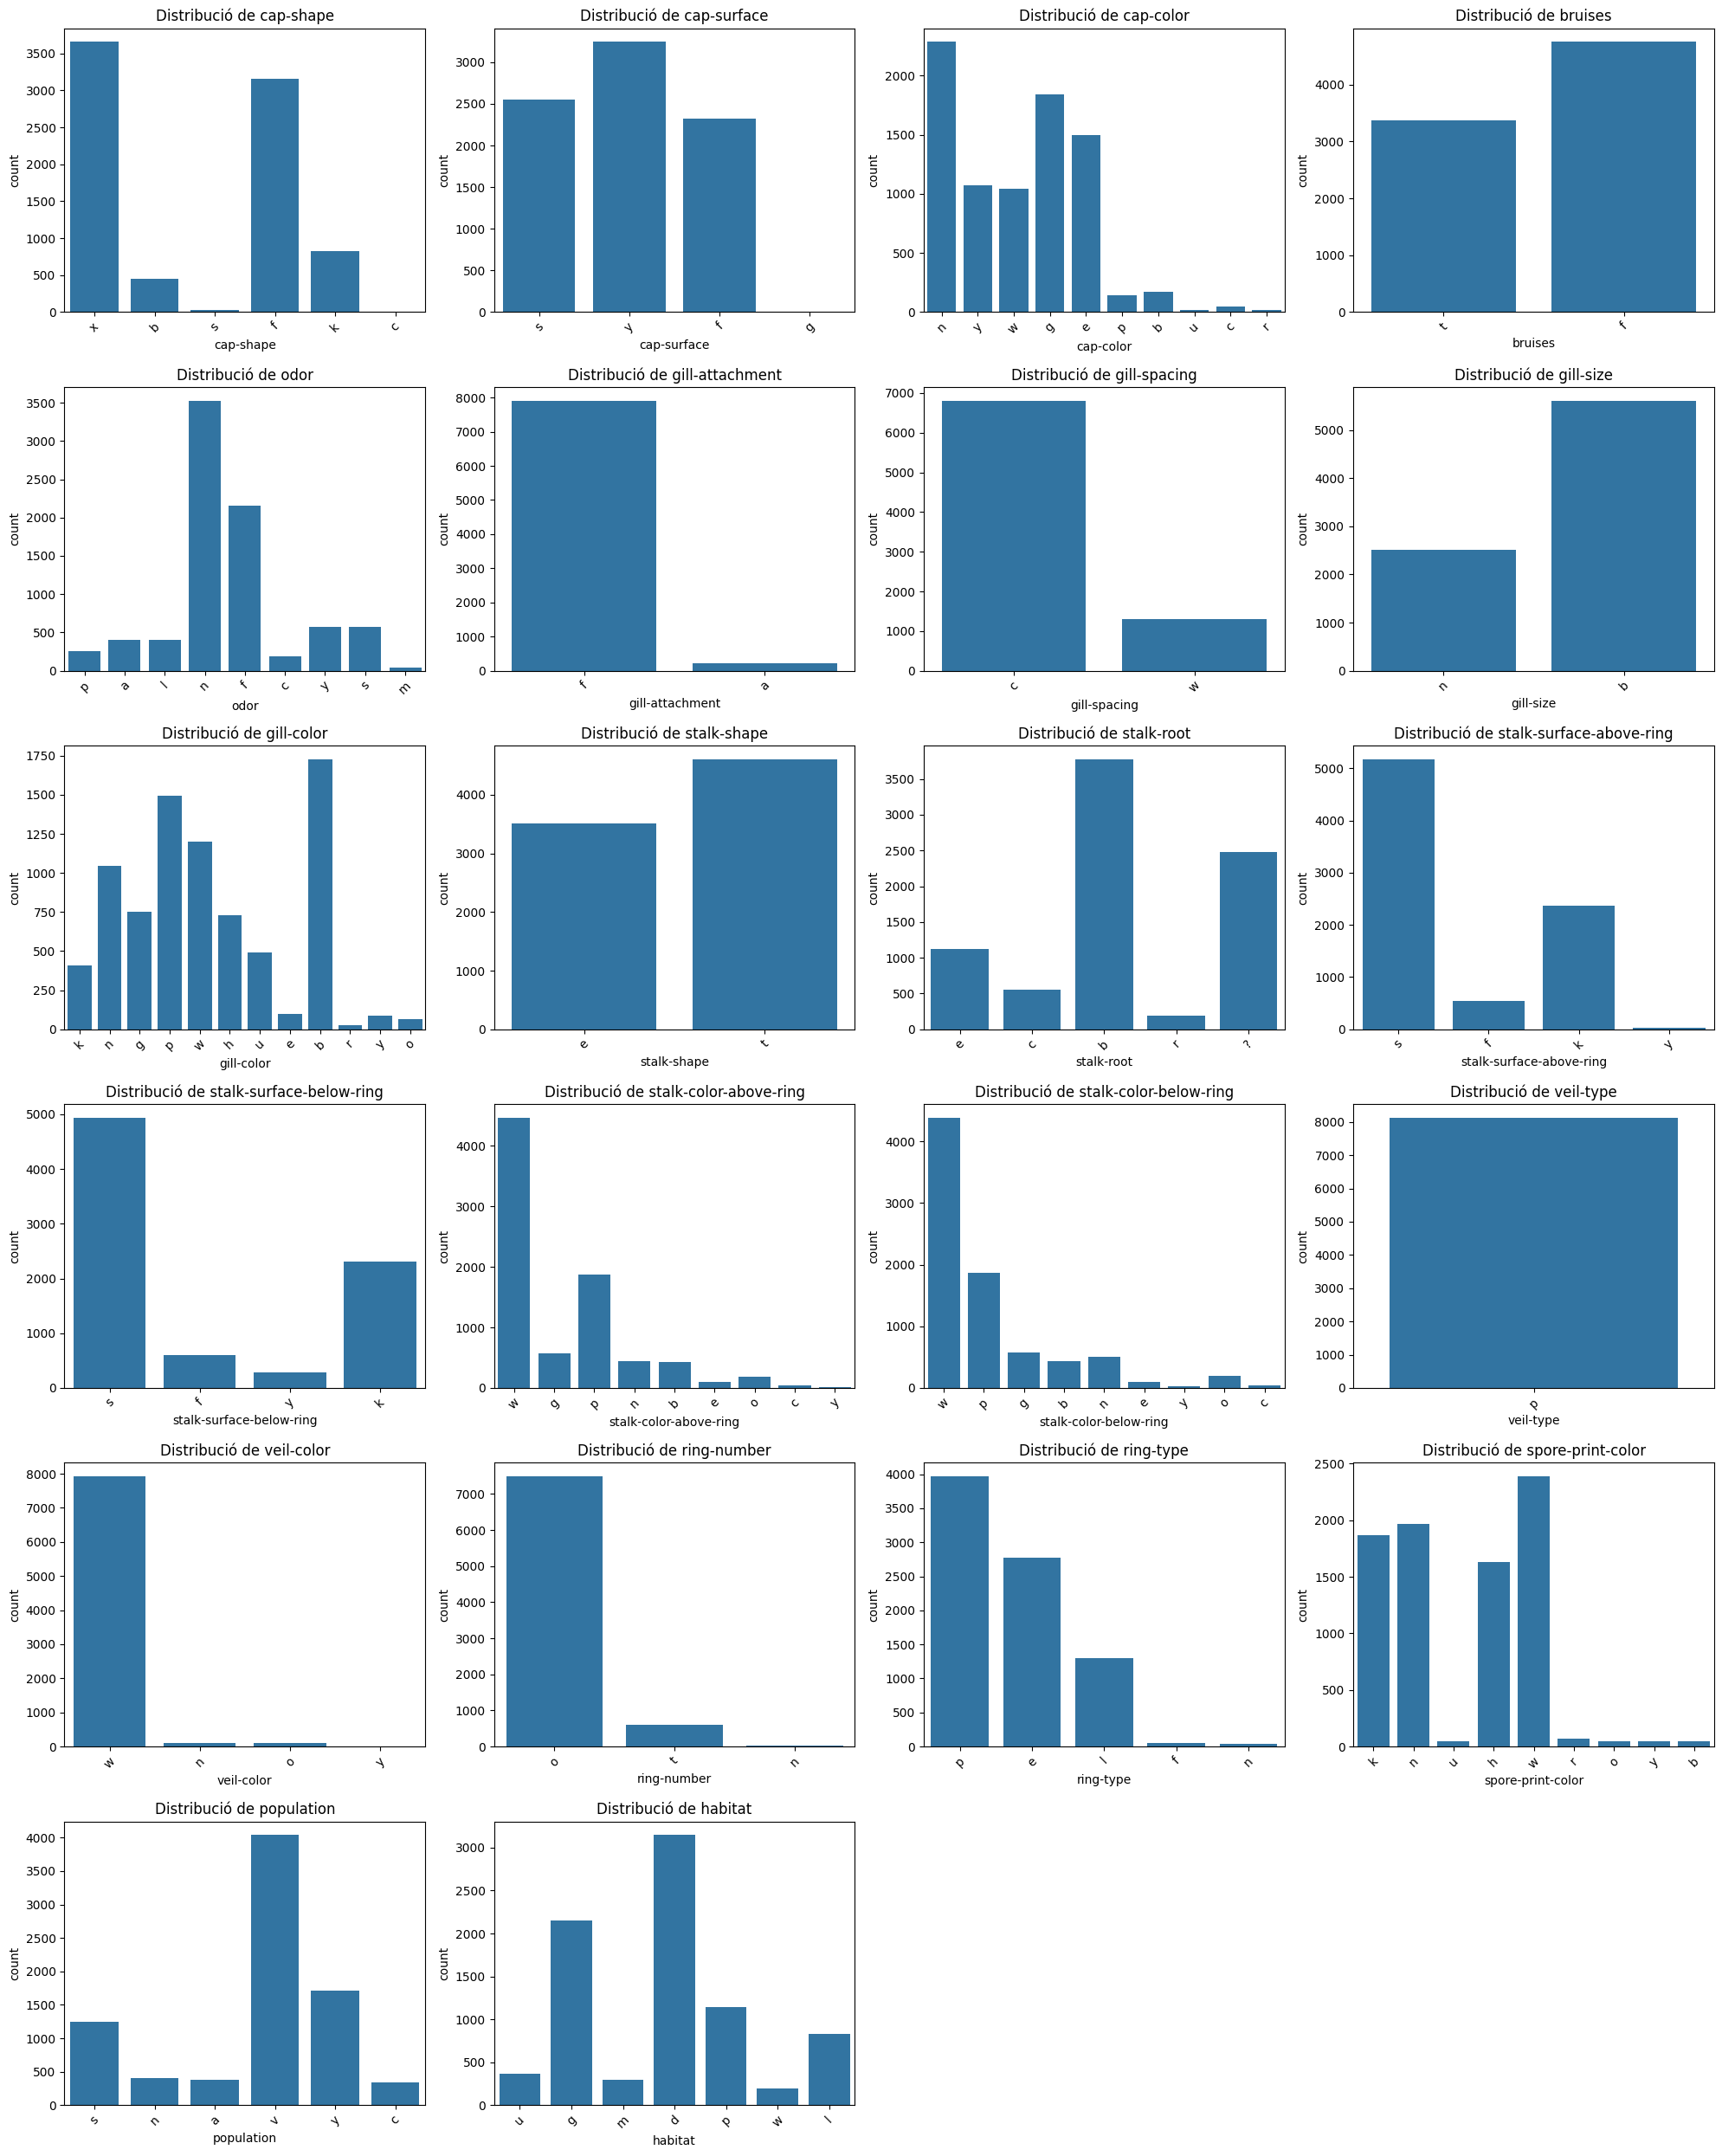

In [7]:
columns_to_plot = data.columns.drop('class')

fig, axes = plt.subplots(nrows=len(columns_to_plot)//4 + 1, ncols=4, figsize=(20, len(columns_to_plot)//4 * 5))

axes = axes.flatten() 

for i, column in enumerate(columns_to_plot):
    sns.countplot(x=column, data=data, ax=axes[i])
    axes[i].set_title(f'Distribució de {column}')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Ara dividirem en dades categògiques i numèriques, perque tot i que tenim molt pocs atributs numèrics, les tractarem de formes diferents. Per exemple 'ring-number' el podrem posar en una sola columna amb valors que vagin del 0 al 2 mentre que per 'ring-type' podrem crear una columna per cada atribut.

In [8]:
data_transformed = data.copy()

numeric_mappings = {
    'gill-size': {'n': 0, 'b': 1},
    'ring-number': {'n': 0, 'o': 1, 't': 2}
}

for column, mapping in numeric_mappings.items():
    data_transformed[column] = data_transformed[column].map(mapping)

#Guardem en una variables les categòriques de les numèriques
categorical_columns = [col for col in data.columns if col not in numeric_mappings.keys()]
numeric_columns = list(numeric_mappings.keys())

print("Columnes categòriques:")
print(categorical_columns)

print("\nColumnes numèriques:")
print(numeric_columns)

Columnes categòriques:
['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-type', 'spore-print-color', 'population', 'habitat']

Columnes numèriques:
['gill-size', 'ring-number']


A continuació amb l'objectiu de reduir l'overfitting, eliminarem les files de les columnes categòriques amb atributs on un valor únic representa menys d'un 2% de les daades d'aquella columna i posteriorment eliminarem totes les columnes amb només un únic atribut ja que no aporten res a la classificació.

In [9]:
data_cleaned = data_transformed.copy()

threshold_percentage = 0.02
total_rows = len(data_cleaned)

for col in categorical_columns:
    if col in data_cleaned.columns:
        threshold = total_rows * threshold_percentage
        
        rare_values = data_cleaned[col].value_counts()[data_cleaned[col].value_counts() < threshold].index
        
        if len(rare_values) > 0:
            print(f"Columna {col} - Valors rars eliminats: {list(rare_values)}")
            
            data_cleaned = data_cleaned[~data_cleaned[col].isin(rare_values)]
            
columns_to_drop = [col for col in categorical_columns if data_cleaned[col].nunique() == 1]
data_cleaned.drop(columns=columns_to_drop, inplace=True)
print(f"Columnes eliminades per tenir un únic valor: {columns_to_drop}")


Columna cap-shape - Valors rars eliminats: ['s', 'c']
Columna cap-surface - Valors rars eliminats: ['g']
Columna cap-color - Valors rars eliminats: ['p', 'c', 'u', 'r']
Columna odor - Valors rars eliminats: ['c', 'm']
Columna gill-color - Valors rars eliminats: ['e', 'y', 'o', 'r']
Columna stalk-surface-above-ring - Valors rars eliminats: ['y']
Columna stalk-color-above-ring - Valors rars eliminats: ['o', 'e']
Columna stalk-color-below-ring - Valors rars eliminats: ['e', 'y']
Columna ring-type - Valors rars eliminats: ['f']
Columna spore-print-color - Valors rars eliminats: ['u', 'r']
Columna population - Valors rars eliminats: ['c']
Columnes eliminades per tenir un únic valor: ['gill-attachment', 'veil-type', 'veil-color']


Tornem a mostrar el datasset gràficament per apreciar els canvis.

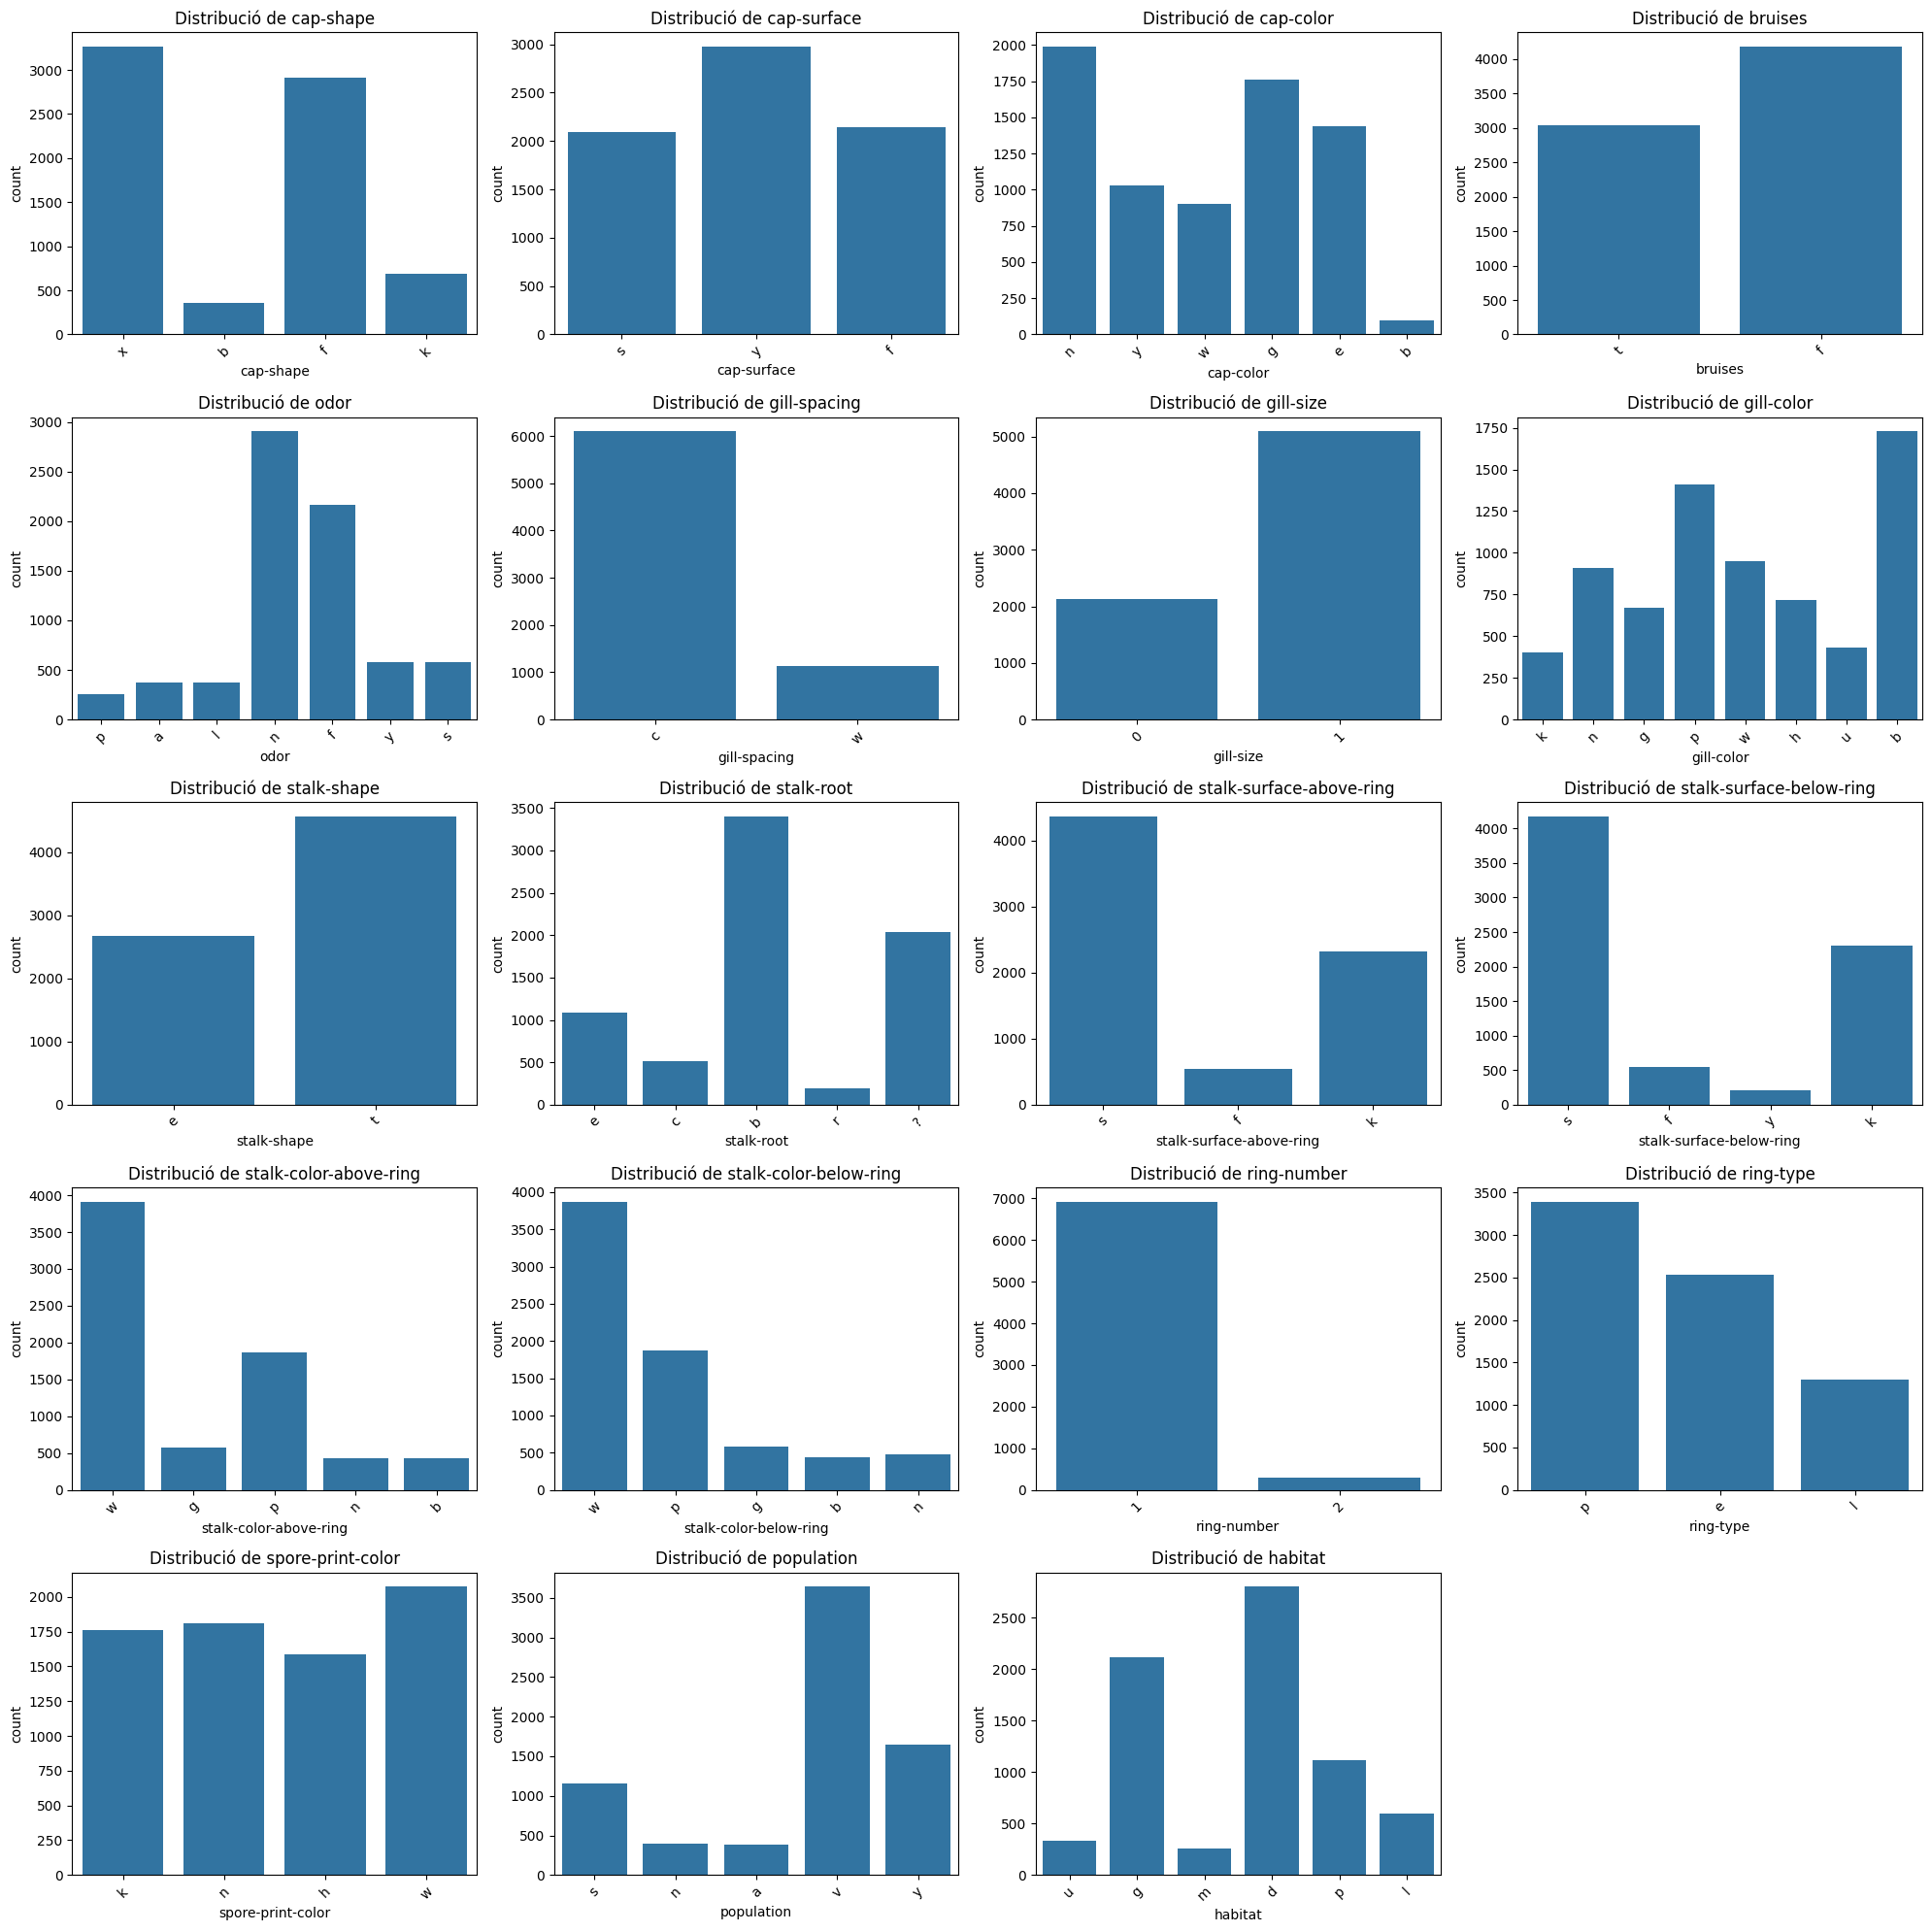

In [10]:
columns_to_plot = data_cleaned.columns.drop('class')

fig, axes = plt.subplots(nrows=len(columns_to_plot)//4 + 1, ncols=4, figsize=(20, len(columns_to_plot)//4 * 5))

axes = axes.flatten() 

for i, column in enumerate(columns_to_plot):
    sns.countplot(x=column, data=data_cleaned, ax=axes[i])
    axes[i].set_title(f'Distribució de {column}')
    axes[i].tick_params(axis='x', rotation=45)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

A la distribució em comprobat que hi han variables que o bé només tenen un valor únic (pel que no aportaran a la classificació) o tenen alguns vEn l'anàlisi de distribució, hem detectat que algunes variables tenen només un valor únic, cosa que les fa irrelevants per a la classificació, ja que no aporten variabilitat al model. També hem observat que certes variables tenen valors que apareixen molt poques vegades, fet que podria perjudicar el rendiment del model si es crea un atribut específic per a aquests casos.

Per aquest això, hem decidit eliminar aquelles variables que considerem poc significatives per a la classificació. Més endavant, verificarem si efectivament no contribuïen de manera significativa al model.alors que apareixen molts pocs cops, pel que alomillor empitjoraria crear un atribut només per determinar si aquell valor hi és o no. Per això, em decidit eliminar les variables que creiem no aportaran a la classificació i després comprovarem si no aportaben.

A continuació, utilitzem one hot encoder per a les variables categòriques (que són pràcticament totes) perquè els nostres models puguin fer una millor classificació, ja que no interpreten la proximitat numèrica entre valors categòrics com una relació inherent, així podem evitar errors en la similitud de les categories.

In [11]:
data_transformed2 = data_cleaned.copy()

categorical_columns = [col for col in data_transformed2.columns if col not in numeric_columns and col != 'class']

encoder = OneHotEncoder(sparse_output=False, drop='first')

categorical_data = encoder.fit_transform(data_transformed2[categorical_columns])

encoded_columns = encoder.get_feature_names_out(categorical_columns)

categorical_encoded_df = pd.DataFrame(categorical_data, columns=encoded_columns, index=data_transformed2.index)

data_final = pd.concat([data_transformed2[numeric_columns], categorical_encoded_df], axis=1)

data_final['class'] = data_transformed2['class']

data_final


,gill-size,ring-number,cap-shape_f,cap-shape_k,cap-shape_x,cap-surface_s,cap-surface_y,cap-color_e,cap-color_g,cap-color_n,...,population_n,population_s,population_v,population_y,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,class
0,0,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,p
1,1,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,e
2,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,e
3,0,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,p
4,1,1,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,e
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8113,0,1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,p
8116,0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,p
8117,0,1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,p
8118,0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,p


## Avaluació de models

Preparem els conjunts de training i de test

In [12]:
class_percentage = data_final['class'].value_counts(normalize=True) * 100
print("Percentatge de cada classe:")
print(class_percentage)

X = data_final.drop('class', axis=1)
y = data_final['class']
y = y.replace({'e': 0, 'p': 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Percentatge de cada classe:
class
e    50.387597
p    49.612403
Name: proportion, dtype: float64


C:\Users\p2004\AppData\Local\Temp\ipykernel_15596\423850292.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({'e': 0, 'p': 1})


Com que la classe que volem predir és molt equilibrada, podem fer servir l'accuracy per avaluar el nostre model.

Avaluem diferents models amb diferents paràmetres amb GridSearch

In [13]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Random Forest": RandomForestClassifier(random_state=0),
    "Logistic Regression": LogisticRegression(random_state=0, max_iter=400),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(random_state=0),
}
param_grid = {
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10, 100],
    },
    "Random Forest": {
        'n_estimators': [50, 100],
        'max_depth': [10, 20],
    },
    "KNN": {
        'n_neighbors': [3, 5, 7, 10],
    },
    "SVM": {
        'C': [0.1, 0.5, 1, 1.5, 2, 3, 10],
    },
    "Decision Tree": {
        'max_depth': [5, 10, 15],
    }
}

best_results = {}

for model_name, model in models.items():
    print(f"Evaluant model: {model_name}")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid[model_name],
        scoring='f1',
        cv=5,
        refit=True
    )
    grid_search.fit(X_train, y_train)

    best_results[model_name] = {
        "Best Score": grid_search.best_score_,
        "Best Parameters": grid_search.best_params_
    }

best_results_df = pd.DataFrame([
    {"Model": model, "Best Score": data["Best Score"], "Best Params": data["Best Parameters"]}
    for model, data in best_results.items()
])
best_results_df = best_results_df.sort_values(by='Best Score', ascending=False)

print("\nMillors resultats:")
print(best_results_df)

best_model_name = best_results_df.iloc[0]['Model']
best_model_params = best_results[best_model_name]["Best Parameters"]
best_model = models[best_model_name].set_params(**best_model_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print(f"\nEvaluació del millor model ({best_model_name}) en el conjunt de prova:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Evaluant model: Decision Tree
Evaluant model: Random Forest
Evaluant model: Logistic Regression
Evaluant model: KNN
Evaluant model: SVM

Millors resultats:
                 Model  Best Score                            Best Params
0        Decision Tree         1.0                       {'max_depth': 5}
1        Random Forest         1.0  {'max_depth': 10, 'n_estimators': 50}
2  Logistic Regression         1.0                             {'C': 0.1}
3                  KNN         1.0                     {'n_neighbors': 3}
4                  SVM         1.0                             {'C': 0.1}

Evaluació del millor model (Decision Tree) en el conjunt de prova:
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       728
           1       1.00      1.00      1.00       717

    accuracy                           1.00      1445
   macro avg       1.00      1.00      1.00      1445
weighted avg       1.00      1.00      1.00   

Com podem observar, el nostre model aconsegueix un accuracy perfecte en tots els casos. En aquest cas ens diu que el decision tree es el millor pero realment és indiferent ja que tots els models aconsegueixen la màxima puntuació.

En aquest experiment, hem obtingut un accuracy perfecte amb un Decision Tree de profunditat 4. Això vol dir que el model aconsegueix classificar tots els bolets correctament, amb un 100% d'encert. Això no vol dir que el model sigui millor que els altres, sinó que les variables del conjunt de dades ja són prou discriminatòries.

Per exemple, variables com l'olor o la superfície del peu del bolet han resultat ser tan distintives que permeten al model identificar si un bolet és verinós o no amb molt poques comparacions. Aquestes característiques són molt clares i poden ser suficients per classificar el bolet de manera correcta, sense necessitat d'un model més complicat o amb més profunditat.

A més, ens han donat una gran quantitat de atributs que aporten molta informació rellevant per la classificació. Tot i així, amb només una profunditat de 4, és capaç de aconseguir una puntuació perfecte.

Accuracy del model: 1.0000


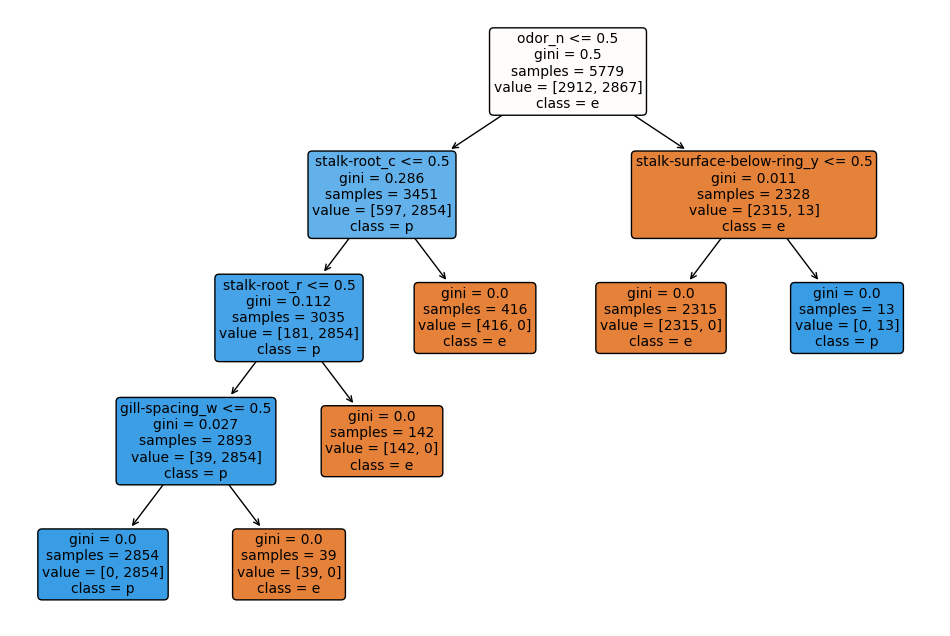

In [14]:
decision_tree = DecisionTreeClassifier(max_depth=4, random_state=42)
decision_tree.fit(X_train, y_train)

y_pred = decision_tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del model: {accuracy:.4f}")

plt.figure(figsize=(12, 8))
plot_tree(decision_tree, 
          filled=True,
          feature_names=X.columns, 
          class_names=['e', 'p'],
          rounded=True,
          fontsize=10) 
plt.show()

Extraiem la importància de totes lea features:

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

importances = model.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

                       Feature  Importance
15                      odor_n    0.140461
13                      odor_f    0.105064
0                    gill-size    0.074762
46                 ring-type_p    0.071041
34  stalk-surface-below-ring_k    0.056192
12                   bruises_t    0.046230
19              gill-spacing_w    0.042214
52                population_v    0.038524
48         spore-print-color_n    0.036711
32  stalk-surface-above-ring_k    0.035284
47         spore-print-color_k    0.030405
49         spore-print-color_w    0.027144
30                stalk-root_e    0.025346
16                      odor_p    0.024912
35  stalk-surface-below-ring_s    0.021866
45                 ring-type_l    0.020544
58                   habitat_u    0.020526
33  stalk-surface-above-ring_s    0.019856
54                   habitat_g    0.015249
29                stalk-root_c    0.015009
28                stalk-root_b    0.014984
40    stalk-color-above-ring_w    0.011333
27         